### Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Data Loading

In [2]:
batch_size = 16
train_batches = tf.keras.utils.image_dataset_from_directory(
    "ChestX-ray14-resized/binary",
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)
test_batches = tf.keras.utils.image_dataset_from_directory(
    "ChestX-ray14-resized/binary",
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)
train_batches = train_batches.map(lambda x,y: (tf.keras.applications.resnet50.preprocess_input(x),y))
test_batches = test_batches.map(lambda x,y: (tf.keras.applications.resnet50.preprocess_input(x),y))

Found 25596 files belonging to 2 classes.
Using 20477 files for training.


2022-06-22 18:51:34.908241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 18:51:34.947528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 18:51:34.947673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 18:51:34.948606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 25596 files belonging to 2 classes.
Using 5119 files for validation.


### Model Building

In [3]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output
output = GlobalAveragePooling2D()(conv)
output = Dense(2, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
opt2=tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])


checkpoint=  ModelCheckpoint(filepath = 'ResNet50.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=40, min_delta=0.001)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Model Training

In [4]:
history = model.fit(train_batches,
                    epochs=300,
                    verbose=1,
                    validation_data=test_batches,
                    callbacks=[checkpoint,Earlystop],
                    class_weight={0:1, 1:4}
                    )

from tensorflow.keras import models
import pickle
model.load_weights("ResNet50.hdf5")
with open("Pneumo_model.pkl","wb") as file:
    pickle.dump(model, file)

Epoch 1/300


2022-06-22 18:52:03.616767: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


1280/1280 [==============================] - 227s 172ms/step - loss: 0.7528 - accuracy: 0.8238 - val_loss: 0.2940 - val_accuracy: 0.8842
Epoch 2/300
1280/1280 [==============================] - 227s 177ms/step - loss: 0.6044 - accuracy: 0.8512 - val_loss: 0.2772 - val_accuracy: 0.8949
Epoch 3/300
1280/1280 [==============================] - 226s 176ms/step - loss: 0.5256 - accuracy: 0.8673 - val_loss: 0.2921 - val_accuracy: 0.8914
Epoch 4/300
1280/1280 [==============================] - 229s 179ms/step - loss: 0.4531 - accuracy: 0.8838 - val_loss: 0.3679 - val_accuracy: 0.8371
Epoch 5/300
1280/1280 [==============================] - 229s 179ms/step - loss: 0.3846 - accuracy: 0.8981 - val_loss: 0.4771 - val_accuracy: 0.8967
Epoch 6/300
1280/1280 [==============================] - 229s 179ms/step - loss: 0.3286 - accuracy: 0.9127 - val_loss: 0.5242 - val_accuracy: 0.7451
Epoch 7/300
1280/1280 [==============================] - 229s 179ms/step - loss: 0.2938 - accuracy: 0.9248 - val_loss:

INFO:tensorflow:Assets written to: ram://a8438dce-470f-493c-a7ea-1b04731b8f06/assets


INFO:tensorflow:Assets written to: ram://a8438dce-470f-493c-a7ea-1b04731b8f06/assets


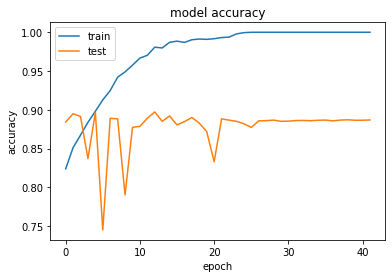

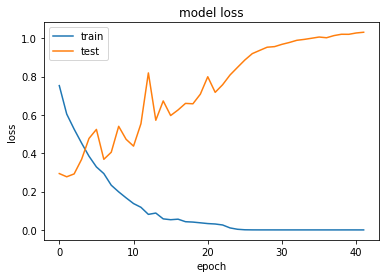

In [5]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
y_pred = model.evaluate(test_batches)

440/440 [==============================] - 22s 50ms/step - loss: 0.4565 - accuracy: 0.8175


### Model Loading

In [7]:
import pickle
with open("Pneumo_model.pkl","rb") as file:
    loaded_model = pickle.load(file)

### Prediction

In [8]:
predictions = loaded_model.predict(test_batches)

320/320 [==============================] - 16s 46ms/step


In [9]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['Negative', 'Positive']
#getting the true labels per image 
y_true = tf.argmax(np.concatenate([y for x, y in test_batches], axis=0), axis=1)
#getting the predicted labels per image 
y_prob=predictions

y_test = tf.keras.utils.to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.98      0.93      4577
    Positive       0.13      0.03      0.05       542

    accuracy                           0.88      5119
   macro avg       0.51      0.50      0.49      5119
weighted avg       0.81      0.88      0.84      5119



In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.6921457758114316
Recall: 0.7564412811387901
Accuracy: 0.7564412811387901
weighted Roc score: 0.5137486931159468


In [46]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.5081820756417188
Recall: 0.5041295327079001
Accuracy: 0.7564412811387901
Macro Roc score: 0.5137486931159468


In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.7564412811387901
Recall: 0.7564412811387901
Accuracy: 0.7564412811387901
Micro Roc score: 0.780333511480351


In [49]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of Negative is: 0.5137486931159468
The ROC AUC score of Positive is: 0.5137486931159468


In [8]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

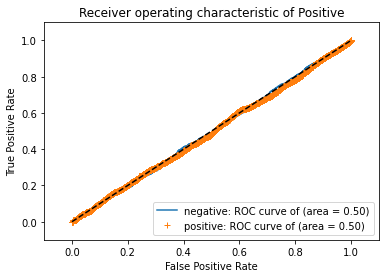

In [9]:

plt.plot(fpr[0], tpr[0],'-',label='negative: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'+',label='positive: ROC curve of (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()